# Market generator

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import datetime

import base
import market_generator
from utils import tosig

ModuleNotFoundError: No module named 'pandas_datareader'

In [ ]:
# Signature order
order = 4

## Load monthly paths

In [2]:
# ^GSPC is S&P 500.
ticker = "^GSPC"
MG = market_generator.MarketGenerator(ticker, start=datetime.date(2001, 1, 1),
                                      freq="M", sig_order=order,read_type=1)

NameError: name 'market_generator' is not defined

In [3]:
from utils.leadlag import leadlag

In [4]:
windows = []
windows_values = []
i = 0
for _, window in MG.data.resample('M'):
    # print(window,'data',i)
    values = window.values
    path = leadlag(values)
    windows.append(path)
    windows_values.append(values)
    i+=1

NameError: name 'MG' is not defined

In [6]:
# 和conditon idx一样

## Plot paths

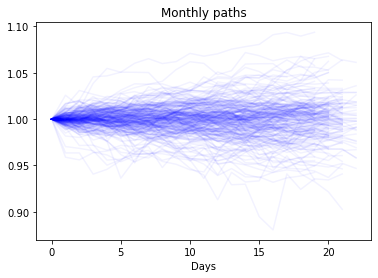

In [7]:
for path in MG.windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.05)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Train generative model

In [8]:
MG.train(n_epochs=10000)

/home/notebook/private/test/flex_work/kuanke_project/Parities_project/test/market_simulator-master/notebooks/../src/cvae.py:24: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  x = tf.layers.flatten(x)
/home/notebook/private/test/flex_work/kuanke_project/Parities_project/test/market_simulator-master/notebooks/../src/cvae.py:25: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.layers.dense(x, units=self.n_hidden, activation=self.lrelu)
/home/notebook/private/test/flex_work/kuanke_project/Parities_project/test/market_simulator-master/notebooks/../src/cvae.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  mn = tf.layers.dense(x, units=self.n_latent, activation=self.lrelu)
/home/notebook/private/test/flex_work/kuanke_project/Par

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
MG.conditions

array([[0.45750449, 0.45750449, 0.99999   , ..., 0.97647269, 0.9644634 ,
        0.97075622],
       [0.4915009 , 0.4915009 , 0.95936118, ..., 0.97504914, 0.96290457,
        0.96897211],
       [0.60563169, 0.60563169, 0.90650404, ..., 0.97458574, 0.96194959,
        0.96617723],
       ...,
       [0.46017564, 0.46017564, 0.97938176, ..., 0.97527437, 0.96305251,
        0.96921136],
       [0.52719712, 0.52719712, 0.98983498, ..., 0.97629471, 0.9642449 ,
        0.97050482],
       [0.84992015, 0.84992015, 0.92738092, ..., 0.97233831, 0.95867957,
        0.9628903 ]])

In [11]:
MG.scaler.inverse_transform(MG.conditions)

array([[-1.05000000e+00, -1.05000000e+00, -2.83450000e-01, ...,
        -4.78489167e-03,  9.35319875e-03,  5.05704333e-03],
       [-3.50000000e-01, -3.50000000e-01, -2.37315000e+00, ...,
        -1.00759793e+00, -1.72893384e+00, -8.74323445e-01],
       [ 2.00000000e+00,  2.00000000e+00, -5.09180000e+00, ...,
        -1.33404494e+00, -2.79385041e+00, -2.25190530e+00],
       ...,
       [-9.95000000e-01, -9.95000000e-01, -1.34341250e+00, ...,
        -8.48936329e-01, -1.56396035e+00, -7.56394276e-01],
       [ 3.85000000e-01,  3.85000000e-01, -8.05762500e-01, ...,
        -1.30163441e-01, -2.34299056e-01, -1.18854521e-01],
       [ 7.03000000e+00,  7.03000000e+00, -4.01802025e+00, ...,
        -2.91724461e+00, -6.44032373e+00, -3.87201153e+00]])

## Generate

In [12]:
generated = np.array([MG.generate(cond) for cond in MG.conditions])
#generated = MG.generate(MG.conditions[100], n_samples=len(MG.logsigs))
#generated = MG.generate(MG.conditions[150][2] * 0.5, n_samples=len(MG.logsigs))

generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.orig_logsig)])

 74%|███████▍  | 183/247 [00:04<00:01, 38.83it/s]

KeyboardInterrupt: 

In [ ]:
MG.generate(MG.conditions[0],normalised=True)

In [ ]:
MG.orig_logsig

In [ ]:
generated.shape

In [ ]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(real_sigs[:, projection[0]], real_sigs[:, projection[1]],
                label="Real data")
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated")
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Validation: two-sample statistical test

In [ ]:
import process_discriminator

normalised_generated = np.array([MG.generate(cond, normalised=True) for cond in MG.conditions])
sigs1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(normalised_generated)])
sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.logsigs)])

res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))

## Invert log-signature

In [ ]:
import logsig_inversion
from esig.tosig import stream2logsig
from utils.leadlag import leadlag

logsig = MG.generate(MG.conditions[0])

In [ ]:
%%time
pip = 0.0001 #0.01
n_pips = 5 * 10000
n_points = 21#21

n_iterations = 100 #循环次数
n_organisms = 400 #生物  

recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

In [ ]:
plt.plot(recovered_path)
plt.show()
print(f"Target log-signature: {logsig.tolist()}")
print(f"Recovered log-signature: {stream2logsig(leadlag(recovered_path), order).tolist()}")

In [ ]:
len(MG.conditions)

In [ ]:
paths = []
for condition in tqdm(MG.conditions):
    logsig = MG.generate(condition)
    recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                                  pip, n_pips)
    
    paths.append(recovered_path)

In [ ]:
len(paths)

In [ ]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8, 6))
for path1, path2 in zip(paths, MG.windows):
    returns = path2[::2, 1][:20] - path2[0, 1]
    plt.plot(returns, "C1", alpha=0.25)

    plt.plot(path1[:20], "C0", alpha=0.25)
    
    
blue_patch = mpatches.Patch(color='C0', label='Generated paths')
red_patch = mpatches.Patch(color='C1', label='Real paths')
plt.legend(handles=[blue_patch, red_patch], fontsize=12)    
plt.xlabel("Days", fontsize=14) 
plt.show()

In [ ]:
returns1 = [path[-1] - path[0] for path in paths]
returns2 = [path[-1, 1] - path[0, 0] for path in MG.windows]

_ = plt.hist([returns1, returns2], bins=20, label=["Real paths", "Generated paths"])
plt.xlabel("Monthly return", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [ ]:
def concatenate(condition, periods):#periods 期 一单元是一个月 所以3期就是 3*1 = 3个月
    joined_path = None

    for _ in range(periods):
        generated = MG.generate(condition)
        path, loss = logsig_inversion.train(generated, order, n_iterations, n_organisms, n_points,#window
                                            pip, n_pips)

        condition = tosig.stream2logsig(market_generator.leadlag(recovered_path), order)
        condition = MG.scaler.transform([condition])[0]

        if joined_path is None:
            joined_path = path
        else:
            joined_path = np.r_[joined_path, np.add(path[1:], joined_path[-1])]#!
            
    return joined_path

In [ ]:
idx = 195 #从第几天开始模拟 找到当天对应的id
#  低波动率
condition = MG.conditions[idx]

paths = [concatenate(condition, 1) for _ in range(40)]# 条数 生成几条数据

plt.plot(np.transpose(paths))
plt.show()

In [ ]:
plt.plot(MG.windows[idx + 1][0, 0] + np.transpose(paths))
plt.plot(windows_values[idx + 1],'bo')
plt.xlabel("Days", fontsize=14) 
plt.show()#

In [ ]:
idx = 69 #从第几天开始模拟 找到当天对应的id
#  高
condition = MG.conditions[idx]

paths2 = [concatenate(condition, 1) for _ in range(40)]# 条数 生成几条数据

plt.plot(np.transpose(paths2))
plt.show()

In [ ]:
plt.plot(MG.windows[idx + 1][0, 0] + np.transpose(paths2))
plt.plot(windows_values[idx + 1],'bo')
plt.xlabel("Days", fontsize=14) 
plt.show()#

In [ ]:
plt.plot(np.array(paths).std(axis=0)**2,color='r')
plt.plot(np.array(paths2).std(axis=0)**2,color='b')

 74%|███████▍  | 183/247 [00:20<00:01, 38.83it/s]